# Лабораторная работа № 4

# Линейные модели, SVM и деревья решений

## Задание:

1. Выберите набор данных (датасет) для решения задачи классификации или регрессии.
2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.
3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.
4. Обучите следующие модели:
   - одну из линейных моделей;
   - SVM;
   - дерево решений.
5. Оцените качество моделей с помощью двух подходящих для задачи метрик. Сравните качество полученных моделей.

## Выполнение:

### Импорт библиотек

In [51]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_diabetes
from io import StringIO 
from IPython.display import Image
import graphviz 
import pydotplus
from operator import itemgetter
from sklearn.impute import SimpleImputer, MissingIndicator
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(style="ticks")

### Подготовка данных

В качестве датасета будем использовать набор данных о погодных условиях на Второй мировой войне: https://www.kaggle.com/smid80/weatherww2/data?select=Summary+of+Weather.csv

In [3]:
data = pd.read_csv('Summary of Weather.csv', sep=",")

/Users/kalashnikova/opt/anaconda3/envs/myenv/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7,8,18,25) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
# Размер набора данных
data.shape

(119040, 31)

In [5]:
# Типы колонок
data.dtypes

STA              int64
Date            object
Precip          object
WindGustSpd    float64
MaxTemp        float64
MinTemp        float64
MeanTemp       float64
Snowfall        object
PoorWeather     object
YR               int64
MO               int64
DA               int64
PRCP            object
DR             float64
SPD            float64
MAX            float64
MIN            float64
MEA            float64
SNF             object
SND            float64
FT             float64
FB             float64
FTI            float64
ITH            float64
PGT            float64
TSHDSBRSGF      object
SD3            float64
RHX            float64
RHN            float64
RVG            float64
WTE            float64
dtype: object

In [5]:
# Проверим есть ли пропущенные значения
data.isnull().sum()

STA                 0
Date                0
Precip              0
WindGustSpd    118508
MaxTemp             0
MinTemp             0
MeanTemp            0
Snowfall         1163
PoorWeather     84803
YR                  0
MO                  0
DA                  0
PRCP             1932
DR             118507
SPD            118508
MAX               474
MIN               468
MEA               498
SNF              1163
SND            113477
FT             119040
FB             119040
FTI            119040
ITH            119040
PGT            118515
TSHDSBRSGF      84803
SD3            119040
RHX            119040
RHN            119040
RVG            119040
WTE            119040
dtype: int64

In [6]:
# Первые 5 строк датасета
data.head()

,STA,Date,Precip,WindGustSpd,MaxTemp,MinTemp,MeanTemp,Snowfall,PoorWeather,YR,...,FB,FTI,ITH,PGT,TSHDSBRSGF,SD3,RHX,RHN,RVG,WTE
0,10001,1942-7-1,1.016,NaN,25.555556,22.222222,23.888889,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,10001,1942-7-2,0,NaN,28.888889,21.666667,25.555556,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10001,1942-7-3,2.54,NaN,26.111111,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,10001,1942-7-4,2.54,NaN,26.666667,22.222222,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,10001,1942-7-5,0,NaN,26.666667,21.666667,24.444444,0.0,NaN,42,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
total_count = data.shape[0]
print("Всего строк: {}".format(total_count))

Всего строк: 119040


### Обработка пропусков в числовых данных

Для создания эффективной модели прогнозирования удалим признаки, в которых пропуски составляют 30% от всех данных или больше.

In [9]:
num_cols = [] # массив числовых признаков с пустыми значениями
cols_to_del = [] # массив числовых признаков на удаление
for col in data.columns:
    count_null = data[data[col].isnull()].shape[0] # кол-во пустых значений
    dt = str(data[col].dtypes)
    if count_null>0 and ((dt == 'int64') or (dt == 'float64')): # проверка на пропуски в числовых значениях
        num_cols.append(col)
        perc_of_missing = round(count_null/total_count * 100, 2)
        if perc_of_missing > 30: # если пропусков больше 30%, то удаляем признак
            cols_to_del.append(col)
        print("Колонка: {}. Тип данных: {}. Количество пустых значений: {}, {}%".format(col, dt, count_null, perc_of_missing))
print(cols_to_del)

Колонка: WindGustSpd. Тип данных: float64. Количество пустых значений: 118508, 99.55%
Колонка: DR. Тип данных: float64. Количество пустых значений: 118507, 99.55%
Колонка: SPD. Тип данных: float64. Количество пустых значений: 118508, 99.55%
Колонка: MAX. Тип данных: float64. Количество пустых значений: 474, 0.4%
Колонка: MIN. Тип данных: float64. Количество пустых значений: 468, 0.39%
Колонка: MEA. Тип данных: float64. Количество пустых значений: 498, 0.42%
Колонка: SND. Тип данных: float64. Количество пустых значений: 113477, 95.33%
Колонка: FT. Тип данных: float64. Количество пустых значений: 119040, 100.0%
Колонка: FB. Тип данных: float64. Количество пустых значений: 119040, 100.0%
Колонка: FTI. Тип данных: float64. Количество пустых значений: 119040, 100.0%
Колонка: ITH. Тип данных: float64. Количество пустых значений: 119040, 100.0%
Колонка: PGT. Тип данных: float64. Количество пустых значений: 118515, 99.56%
Колонка: SD3. Тип данных: float64. Количество пустых значений: 119040, 1

In [10]:
# Удаляем неподходящие признаки
data.drop(cols_to_del, inplace=True, axis=1)
data.shape

(119040, 17)

In [11]:
# Оставшиеся признаки с пустыми значениями
cols_left = [x for x in num_cols if not any(x in y for y in cols_to_del)]
cols_left

['MAX', 'MIN', 'MEA']

In [12]:
left_data = data[cols_left]
left_data

,MAX,MIN,MEA
0,78.0,72.0,75.0
1,84.0,71.0,78.0
2,79.0,72.0,76.0
3,80.0,72.0,76.0
4,80.0,71.0,76.0
...,...,...,...
119035,83.0,65.0,74.0
119036,85.0,65.0,75.0
119037,83.0,65.0,74.0
119038,83.0,65.0,74.0


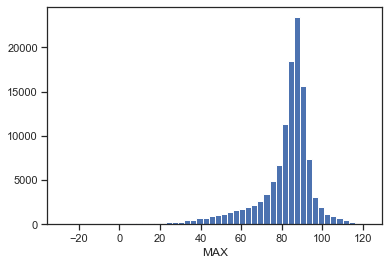

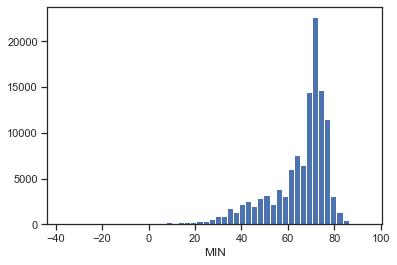

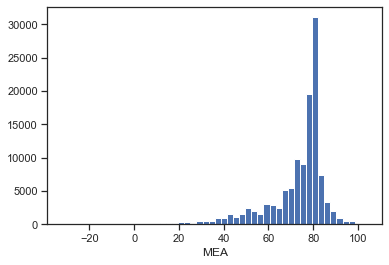

In [13]:
# Гистограмма по признакам
for col in left_data:
    plt.hist(data[col], 50)
    plt.xlabel(col)
    plt.show()

Как видно из гистограмм, распределения всех трех признаков одномодальные. Поэтому заполнять пропуски будем с помощью моды.

In [14]:
# Функция, которая для заданной колонки делает импьютацию по моде
def test_num_impute_col(dataset, column, strat_param):
    temp_data = dataset[[column]]
    
    indicator = MissingIndicator()
    mask_missing_values_only = indicator.fit_transform(temp_data)
    
    imp_num = SimpleImputer(strategy=strat_param)
    data_num_imp = imp_num.fit_transform(temp_data)
    
    filled_data = data_num_imp[mask_missing_values_only]
    
    dataset[column] = dataset[column].fillna(filled_data[0])
    
    return filled_data[0]

In [15]:
test_num_impute_col(data, 'MAX', 'most_frequent')

86.0

In [16]:
test_num_impute_col(data, 'MIN', 'most_frequent')

72.0

In [17]:
test_num_impute_col(data, 'MEA', 'most_frequent')

80.0

### Обработка пропусков в данных, прочитанных некорректно

In [18]:
num_cols =[]
for col in data.columns:
    count_null = data[data[col].isnull()].shape[0] # кол-во пустых значений
    dt = str(data[col].dtypes)
    if count_null>0 and dt == 'object':
        num_cols.append(col)
        perc_of_missing = round(count_null/total_count * 100, 2)
        print("Колонка: {}. Тип данных: {}. Количество пустых значений: {}, {}%".format(col, dt, count_null, perc_of_missing))

Колонка: Snowfall. Тип данных: object. Количество пустых значений: 1163, 0.98%
Колонка: PoorWeather. Тип данных: object. Количество пустых значений: 84803, 71.24%
Колонка: PRCP. Тип данных: object. Количество пустых значений: 1932, 1.62%
Колонка: SNF. Тип данных: object. Количество пустых значений: 1163, 0.98%
Колонка: TSHDSBRSGF. Тип данных: object. Количество пустых значений: 84803, 71.24%


In [19]:
# Удалим признаки с пропусками в данных больше 30%
deleting = ['PoorWeather', 'TSHDSBRSGF']
data.drop(deleting, inplace=True, axis=1)
data.shape

(119040, 15)

Колонки PRCP и SNF дублируют колонки Precip и Snowfall соответственно (первые измеряются в дюймах, вторые в миллиметрах). Удалим колонки PRCP и SNF для создания более точной модели. Затем пройдем по оставшимся колонкам с пропусками и закодируем их.

In [20]:
deleting = ['PRCP', 'SNF']
data.drop(deleting, inplace=True, axis=1)
data.shape

(119040, 13)

In [21]:
data_snowf = data['Snowfall']
data_snowf.unique()

array([0.0, nan, '0', '22.86', '33.02', '30.48', '2.54', '5.08', '10.16',
       '7.62', '20.32', '15.24', '17.78', '12.7', '25.4', '27.94',
       '43.18', '38.1', '45.72', '53.34', '58.42', '66.04', '76.2',
       '81.28', '73.66', '63.5', '50.8', '48.26', '60.96', '55.88',
       '35.56', '78.74', '40.64', '86.36', '83.82', '68.58', '#VALUE!',
       10.16, 7.62, 15.24, 2.54, 5.08, 12.7], dtype=object)

В колонке Snowfall числовые значения записаны в форматах float64 и str. Также есть пропущенное значение '#VALUE', которое лучше преобразовать в пустое (nan).

In [22]:
data['Snowfall'] = data.Snowfall.apply(lambda i: i if i !='#VALUE!' else np.nan)

In [23]:
data_snowf = data['Snowfall']
data_snowf.unique()

array([0.0, nan, '0', '22.86', '33.02', '30.48', '2.54', '5.08', '10.16',
       '7.62', '20.32', '15.24', '17.78', '12.7', '25.4', '27.94',
       '43.18', '38.1', '45.72', '53.34', '58.42', '66.04', '76.2',
       '81.28', '73.66', '63.5', '50.8', '48.26', '60.96', '55.88',
       '35.56', '78.74', '40.64', '86.36', '83.82', '68.58', 10.16, 7.62,
       15.24, 2.54, 5.08, 12.7], dtype=object)

In [24]:
data['Snowfall'] = [float(i) for i in data_snowf]

In [25]:
data['Snowfall'].unique()

array([ 0.  ,   nan, 22.86, 33.02, 30.48,  2.54,  5.08, 10.16,  7.62,
       20.32, 15.24, 17.78, 12.7 , 25.4 , 27.94, 43.18, 38.1 , 45.72,
       53.34, 58.42, 66.04, 76.2 , 81.28, 73.66, 63.5 , 50.8 , 48.26,
       60.96, 55.88, 35.56, 78.74, 40.64, 86.36, 83.82, 68.58])

Колонка Snowfall теперь имеет только числовые признаки.

In [26]:
data['Snowfall']

0         0.0
1         0.0
2         0.0
3         0.0
4         0.0
         ... 
119035    0.0
119036    0.0
119037    0.0
119038    0.0
119039    0.0
Name: Snowfall, Length: 119040, dtype: float64

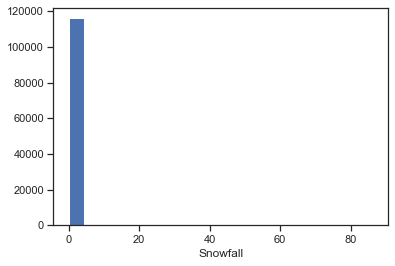

In [27]:
# Гистограмма для признака Snowfall
plt.hist(data['Snowfall'], 20)
plt.xlabel('Snowfall')
plt.show()

In [28]:
test_num_impute_col(data, 'Snowfall', 'mean')

0.24554360832703917

In [29]:
data.isnull().sum()

STA         0
Date        0
Precip      0
MaxTemp     0
MinTemp     0
MeanTemp    0
Snowfall    0
YR          0
MO          0
DA          0
MAX         0
MIN         0
MEA         0
dtype: int64

Все пропуски заполнены.

### Кодирование категориальных признаков

In [30]:
data['Precip'].unique()

array(['1.016', '0', '2.54', 'T', '3.556', '0.508', '0.254', '1.778',
       '3.302', '0.762', '5.588', '5.08', '2.032', '25.654', '40.132',
       '19.05', '23.876', '4.064', '12.192', '2.794', '33.274', '19.304',
       '47.752', '6.35', '3.048', '8.382', '10.16', '27.178', '30.48',
       '45.212', '10.668', '15.494', '57.658', '58.166', '11.43',
       '31.242', '17.78', '26.924', '26.67', '6.604', '5.334', '4.826',
       '7.62', '8.636', '7.874', '12.446', '90.932', '13.462', '11.938',
       '5.842', '4.318', '6.096', '9.144', '4.572', '9.906', '9.652',
       '1.524', '13.97', '17.272', '33.528', '1.27', '13.716', '8.128',
       '22.352', '39.116', '36.068', '98.044', '3.81', '14.986', '78.232',
       '146.304', '14.732', '21.844', '120.904', '42.164', '23.368',
       '21.082', '44.958', '2.286', '50.038', '17.526', '51.054', '7.112',
       '25.4', '7.366', '16.256', '46.736', '8.89', '24.638', '11.684',
       '17.018', '144.78', '18.034', '50.8', '106.426', '36.576', '53.

В описании датасета указано, что в метеорологии T (Trace) используется для описания очень небольшого количества осадков, такого что измерительные приборы не могут его распознать. Поэтому этот показатель эквивалентен нулю.

In [31]:
data['Precip'] = data.Precip.apply(lambda i: float(i) if i !='T' else 0)

In [32]:
data.drop('Date', inplace=True, axis=1)
data.shape

(119040, 12)

In [33]:
# Статистические характеристики датасета
data.describe()

,STA,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,MAX,MIN,MEA
count,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000,119040.000000
mean,29659.435795,3.225612,27.045111,17.789511,22.411631,0.245544,43.805284,6.726016,15.797530,81.023639,64.304183,72.675613
std,20953.209402,10.801044,8.717817,8.334572,8.297982,2.613250,1.136718,3.425561,8.794541,14.843063,14.461088,14.189268
min,10001.000000,0.000000,-33.333333,-38.333333,-35.555556,0.000000,40.000000,1.000000,1.000000,-28.000000,-37.000000,-32.000000
25%,11801.000000,0.000000,25.555556,15.000000,20.555556,0.000000,43.000000,4.000000,8.000000,78.000000,59.000000,69.000000
50%,22508.000000,0.000000,29.444444,21.111111,25.555556,0.000000,44.000000,7.000000,16.000000,85.000000,70.000000,78.000000
75%,33501.000000,0.762000,31.666667,23.333333,27.222222,0.000000,45.000000,10.000000,23.000000,89.000000,74.000000,81.000000
max,82506.000000,307.340000,50.000000,34.444444,40.000000,86.360000,45.000000,12.000000,31.000000,122.000000,94.000000,104.000000


In [34]:
# Отмасштабируем признаки, т.к. min и max у признаков находятся не в одном диапазоне
sc = MinMaxScaler()
data[:] = sc.fit_transform(data)

In [35]:
data

,STA,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,MAX,MIN,MEA
0,0.0,0.003306,0.706667,0.832061,0.786765,0.0,0.4,0.545455,0.000000,0.706667,0.832061,0.786765
1,0.0,0.000000,0.746667,0.824427,0.808824,0.0,0.4,0.545455,0.033333,0.746667,0.824427,0.808824
2,0.0,0.008264,0.713333,0.832061,0.794118,0.0,0.4,0.545455,0.066667,0.713333,0.832061,0.794118
3,0.0,0.008264,0.720000,0.832061,0.794118,0.0,0.4,0.545455,0.100000,0.720000,0.832061,0.794118
4,0.0,0.000000,0.720000,0.824427,0.794118,0.0,0.4,0.545455,0.133333,0.720000,0.824427,0.794118
...,...,...,...,...,...,...,...,...,...,...,...,...
119035,1.0,0.000000,0.740000,0.778626,0.779412,0.0,1.0,1.000000,0.866667,0.740000,0.778626,0.779412
119036,1.0,0.032231,0.753333,0.778626,0.786765,0.0,1.0,1.000000,0.900000,0.753333,0.778626,0.786765
119037,1.0,0.000000,0.740000,0.778626,0.779412,0.0,1.0,1.000000,0.933333,0.740000,0.778626,0.779412
119038,1.0,0.000000,0.740000,0.778626,0.779412,0.0,1.0,1.000000,0.966667,0.740000,0.778626,0.779412


<AxesSubplot:>

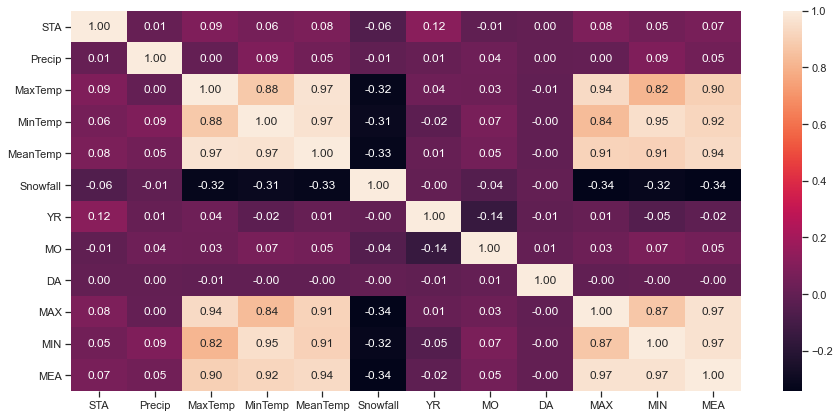

In [36]:
# Построим корреляционную матрицу
fig, ax = plt.subplots(figsize=(15,7))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, fmt='.2f')

<AxesSubplot:xlabel='MinTemp', ylabel='MaxTemp'>

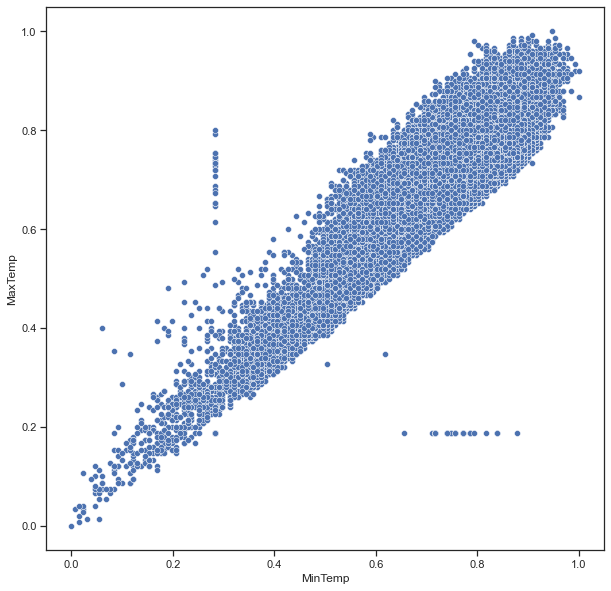

In [37]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(ax=ax, x='MinTemp', y='MaxTemp', data=data)

Между признаком "MinTemp" и целевым признаком "MaxTemp" существует зависимость, близкая к линейной, коэффициент корреляции = 0,88.

Попробуем восстановить данную линейную зависимость.

In [38]:
x_array = data['MinTemp'].values
y_array = data['MaxTemp'].values

In [39]:
reg1 = LinearRegression().fit(x_array.reshape(-1, 1), y_array.reshape(-1, 1))

In [40]:
reg1.coef_, reg1.intercept_

(array([[0.80239616]]), array([0.10577066]))

In [41]:
print('Размер выборки - {}'.format(x_array.shape[0]))
reg2 = SGDRegressor().fit(x_array.reshape(-1, 1), y_array)
reg2.coef_, reg2.intercept_

Размер выборки - 119040


(array([0.76670366]), array([0.1334578]))

### Разделение выборки на обучающую и тестовую

In [42]:
X_train, X_test, Y_train, Y_test = train_test_split(data, data.MaxTemp, test_size=0.3, random_state=1)

In [43]:
# Размер обучающей выборки
X_train.shape, Y_train.shape

((83328, 12), (83328,))

In [44]:
# Размер тестовой выборки
X_test.shape, Y_test.shape

((35712, 12), (35712,))

## Линейная модель

In [44]:
reg1 = LinearRegression().fit(X_train, Y_train)
Y_pred = reg1.predict(X_test)

print('Коэффициенты b1: \n', reg1.coef_)

print('Среднеквадратичная ошибка: %.2f'
      % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print('R2 оценка: %.2f'
      % r2_score(Y_test, Y_pred))

Коэффициенты b1: 
 [ 4.04659131e-16  6.40014353e-16  1.00000000e+00 -5.27280585e-16
  1.50693992e-15 -2.73598181e-16 -2.83950239e-15 -6.37408166e-16
 -1.71207287e-15  7.83288413e-16 -2.55282567e-16  2.17523384e-16]
Среднеквадратичная ошибка: 0.00
R2 оценка: 1.00


In [45]:
print('Размер выборки - {}'.format(X_train.shape[0]))
reg2 = SGDRegressor().fit(X_train, Y_train)
Y_pred = reg2.predict(X_test)
print('Коэффициенты b1: \n', reg2.coef_)

print('Среднеквадратичная ошибка: %.2f'
      % mean_squared_error(Y_test, Y_pred))
# The coefficient of determination: 1 is perfect prediction
print('R2 оценка: %.2f'
      % r2_score(Y_test, Y_pred))

Размер выборки - 83328
Коэффициенты b1: 
 [ 0.00341901 -0.02309911  0.34828283  0.10008552  0.24101606 -0.01261354
  0.00904504 -0.00319802 -0.00110716  0.20458866 -0.02494756  0.09771114]
Среднеквадратичная ошибка: 0.00
R2 оценка: 0.97


## SVR

<AxesSubplot:>

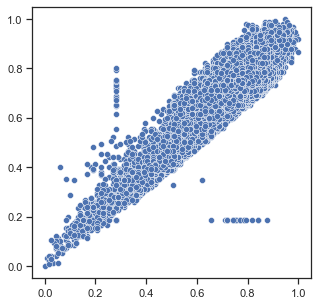

In [46]:
fig, ax = plt.subplots(figsize=(5,5)) 
sns.scatterplot(ax=ax, x=x_array, y=y_array)

In [47]:
def plot_regr(clf):
    title = clf.__repr__
    clf.fit(x_array.reshape(-1, 1), y_array)
    y_pred = clf.predict(x_array.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(x_array, y_array, 'b.')
    ax.plot(x_array, y_pred, 'ro')
    plt.show()

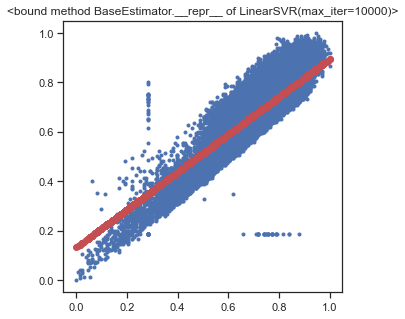

In [48]:
# Линейный регрессор (не поддерживает ядра)
plot_regr(LinearSVR(C=1.0, max_iter=10000))

In [ ]:
# Регрессор на ядре rbf 
plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0))

## Дерево решений

In [53]:
tree = DecisionTreeRegressor(max_depth = 3, random_state = 1)
tree.fit(X_train, Y_train)
Y_pred_tree = tree.predict(X_test)

In [54]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

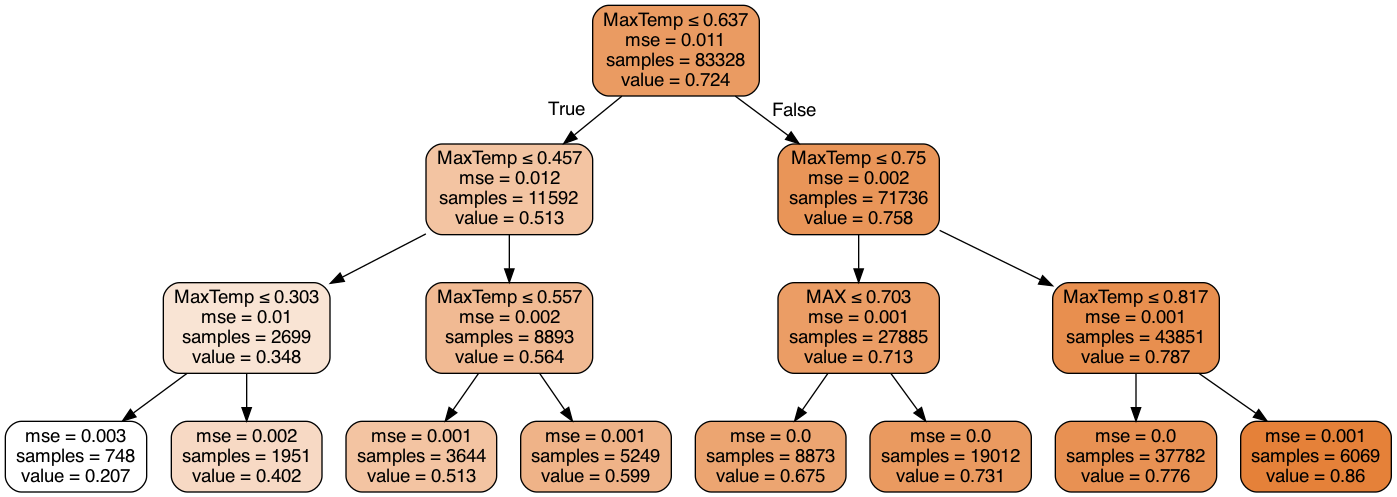

In [55]:
Image(get_png_tree(tree, list(data.columns)), width='80%')

In [56]:
# Важность признаков
list(zip(X_train.columns.values, tree.feature_importances_))

[('STA', 0.0),
 ('Precip', 0.0),
 ('MaxTemp', 0.9787153967404134),
 ('MinTemp', 0.0),
 ('MeanTemp', 0.0),
 ('Snowfall', 0.0),
 ('YR', 0.0),
 ('MO', 0.0),
 ('DA', 0.0),
 ('MAX', 0.0212846032595865),
 ('MIN', 0.0),
 ('MEA', 0.0)]

In [57]:
def draw_feature_importances(tree_model, X_dataset, figsize=(18,5)):
    """
    Вывод важности признаков в виде графика
    """
    # Сортировка значений важности признаков по убыванию
    list_to_sort = list(zip(X_dataset.columns.values, tree_model.feature_importances_))
    sorted_list = sorted(list_to_sort, key=itemgetter(1), reverse = True)
    # Названия признаков
    labels = [x for x,_ in sorted_list]
    # Важности признаков
    data = [x for _,x in sorted_list]
    # Вывод графика
    fig, ax = plt.subplots(figsize=figsize)
    ind = np.arange(len(labels))
    plt.bar(ind, data)
    plt.xticks(ind, labels, rotation='vertical')
    # Вывод значений
    for a,b in zip(ind, data):
        plt.text(a-0.05, b+0.01, str(round(b,3)))
    plt.show()
    return labels, data

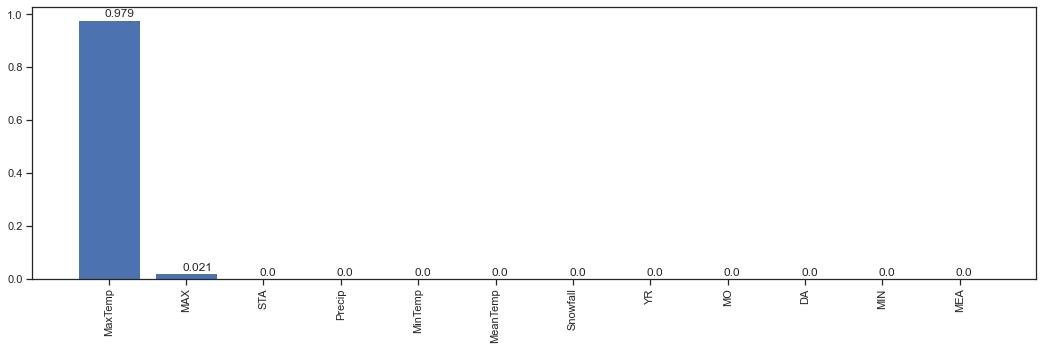

In [58]:
tree_fl, tree_fd = draw_feature_importances(tree, X_train)

In [59]:
# Список отсортированный по важности (по убыв)
tree_fl, tree_fd

(['MaxTemp',
  'MAX',
  'STA',
  'Precip',
  'MinTemp',
  'MeanTemp',
  'Snowfall',
  'YR',
  'MO',
  'DA',
  'MIN',
  'MEA'],
 [0.9787153967404134,
  0.0212846032595865,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0])

In [60]:
data.head()

,STA,Precip,MaxTemp,MinTemp,MeanTemp,Snowfall,YR,MO,DA,MAX,MIN,MEA
0,0.0,0.003306,0.706667,0.832061,0.786765,0.0,0.4,0.545455,0.000000,0.706667,0.832061,0.786765
1,0.0,0.000000,0.746667,0.824427,0.808824,0.0,0.4,0.545455,0.033333,0.746667,0.824427,0.808824
2,0.0,0.008264,0.713333,0.832061,0.794118,0.0,0.4,0.545455,0.066667,0.713333,0.832061,0.794118
3,0.0,0.008264,0.720000,0.832061,0.794118,0.0,0.4,0.545455,0.100000,0.720000,0.832061,0.794118
4,0.0,0.000000,0.720000,0.824427,0.794118,0.0,0.4,0.545455,0.133333,0.720000,0.824427,0.794118


In [61]:
# Пересортируем признаки на основе важности
data_sorted = data[tree_fl]
data_sorted.head()

,MaxTemp,MAX,STA,Precip,MinTemp,MeanTemp,Snowfall,YR,MO,DA,MIN,MEA
0,0.706667,0.706667,0.0,0.003306,0.832061,0.786765,0.0,0.4,0.545455,0.000000,0.832061,0.786765
1,0.746667,0.746667,0.0,0.000000,0.824427,0.808824,0.0,0.4,0.545455,0.033333,0.824427,0.808824
2,0.713333,0.713333,0.0,0.008264,0.832061,0.794118,0.0,0.4,0.545455,0.066667,0.832061,0.794118
3,0.720000,0.720000,0.0,0.008264,0.832061,0.794118,0.0,0.4,0.545455,0.100000,0.832061,0.794118
4,0.720000,0.720000,0.0,0.000000,0.824427,0.794118,0.0,0.4,0.545455,0.133333,0.824427,0.794118


In [62]:
# Исследуем, как изменяется ошибка при добавлении признаков в порядке значимости
X_range = list(range(1, len(X_train.columns)+1))
X_range

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]

In [63]:
mae_list = []
for i in X_range:
    # Обучим дерево и предскажем результаты на заданном количестве признаков 
    tree_3 = DecisionTreeRegressor(random_state=1).fit(
        X_train[tree_fl[0:i]], Y_train)
    Y_test_predict_3 = tree_3.predict(X_test[tree_fl[0:i]])
    temp_mae = mean_absolute_error(Y_test, Y_test_predict_3)
    mae_list.append(temp_mae)

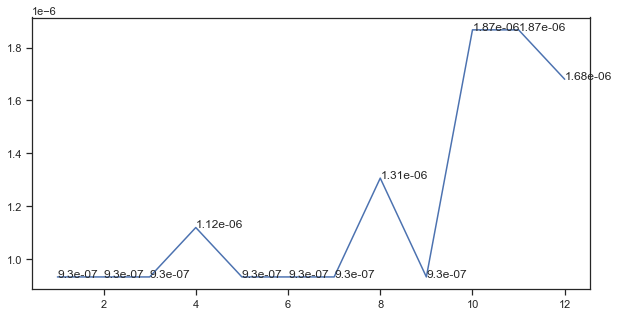

In [64]:
plt.subplots(figsize=(10,5))
plt.plot(X_range, mae_list)
for a,b in zip(X_range, mae_list):
    plt.text(a, b, str(round(b,8)))
plt.show()

## Оценка качества моделей

### 1) Линейная модель

In [65]:
pred_lin = reg1.predict(x_array.reshape(-1,1))
print("MSE:", mean_squared_error(y_array, pred_lin))
print("R2_score:", r2_score(y_array, pred_lin))

MSE: 0.002500055874428001
R2_score: 0.7715582862315506


### 2) SVR

In [66]:
svr = SVR(kernel='rbf')
svrf=svr.fit(X_train, Y_train)
svr_pred=svrf.predict(X_test)
print("MSE:", mean_squared_error(Y_test, svr_pred))
print("R2_score:", r2_score(Y_test, svr_pred))

MSE: 0.0013312099214819175
R2_score: 0.8767114374535686


### 3) Дерево решений

In [67]:
y_tree_pred = tree.predict(X_test)
print("MSE:", mean_squared_error(Y_test, Y_pred_tree))
print("R2_score:", r2_score(Y_test, Y_pred_tree))

MSE: 0.00042856601949213806
R2_score: 0.9603088230888389


Т.к. коэффициент детерминации для всех моделей достаточно высок, можно сделать вывод, что модели достаточно хороши (первая приемлема).